## Chargement du dataset

In [15]:
import numpy as np
import os

# Imports nécessaires pour construire un modèle LeNet 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D 
from tensorflow.keras.layers import Rescaling

# Pour importer le datasets
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory


# Pour la compilation du modèle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Pour visualiser les performances
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

print(tf.__version__)
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
tf.keras.backend.clear_session()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


# Chargement du dataset
#dir_name = "/mnt/c/Users/karim/rakuten/images/data_clean/images_deep/sample"
dir_name = "/mnt/c/Users/karim/rakuten/images/data_clean/images_deep/sample_balanced"
img_size = (224, 224)  # Taille cible
batch_size = 32
class_names = sorted(os.listdir(dir_name))
nb_class = len(class_names)

train_ds = image_dataset_from_directory(
    dir_name,
    image_size=img_size,
    batch_size=batch_size,
    subset="training",
    validation_split=0.2,
    seed=42
)

val_ds = image_dataset_from_directory(
    dir_name,
    image_size=img_size,
    batch_size=batch_size,
    subset="validation",
    validation_split=0.2,
    seed=42
)

# Ajout d'optimisation : mise en cache et préchargement
#train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

def display_results(model_history, model_name):
    # Récupérer les données d'entraînement et de validation
    train_loss = model_history.history["loss"]
    val_loss = model_history.history["val_loss"]
    train_accuracy =  model_history.history["accuracy"]
    val_accuracy = model_history.history["val_accuracy"]
    
    plt.figure(figsize=(20, 8))
    
    # Tracer la perte
    plt.subplot(121)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title(model_name + ": Perte d'entraînement et de validation")
    plt.ylabel('Perte ')
    plt.xlabel('Époque')
    plt.legend(['Entraînement', 'Validation'], loc='best')
    
    # Tracer l'erreur absolue moyenne (MAE)
    plt.subplot(122)
    plt.plot(train_accuracy)
    plt.plot(val_accuracy)
    plt.title(model_name+': Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Époque')
    plt.legend(['Entraînement', 'Validation'], loc='best')
    
    plt.show()

2.19.0
Num GPUs Available:  1
Found 54000 files belonging to 27 classes.
Using 43200 files for training.
Found 54000 files belonging to 27 classes.
Using 10800 files for validation.


## Structure du modèle

In [17]:
import tensorflow as tf

# Modèle de base
base_model = tf.keras.applications.VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Entrée du modèle
inputs = tf.keras.Input(shape=(224, 224, 3))

# Pipeline complet
x = tf.keras.layers.RandomFlip("horizontal")(inputs)
x = tf.keras.layers.RandomRotation(0.2)(x)
x = tf.keras.layers.RandomZoom(0.2)(x)
x = tf.keras.layers.RandomContrast(0.2)(x)

x = tf.keras.layers.Lambda(lambda x: tf.keras.applications.vgg16.preprocess_input(x))(x)
x = base_model(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(nb_class, activation='softmax')(x)

## Entrainement du modèle

Phase 1: Entraînement avec modèle de base gelé
Epoch 1/20


I0000 00:00:1744967214.128446    1865 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-04-18 11:06:55.199758: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-18 11:06:55.693073: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:382] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.0638 - loss: 4.1582  
Epoch 1: val_accuracy improved from -inf to 0.26796, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 210s 149ms/step - accuracy: 0.0639 - loss: 4.1580 - val_accuracy: 0.2680 - val_loss: 3.1163 - learning_rate: 1.0000e-04
Epoch 2/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.1626 - loss: 3.4601  
Epoch 2: val_accuracy improved from 0.26796 to 0.31907, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 200s 148ms/step - accuracy: 0.1626 - loss: 3.4600 - val_accuracy: 0.3191 - val_loss: 2.8457 - learning_rate: 1.0000e-04
Epoch 3/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.2146 - loss: 3.2014  
Epoch 3: val_accuracy improved from 0.31907 to 0.34565, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 199s 148ms/step - accuracy: 0.2146 - loss: 3.2014 - val_accuracy: 0.3456 - val_loss: 2.7031 - learning_rate: 1.0000e-04
Epoch 4/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.2517 - loss: 3.0366  
Epoch 4: val_accuracy improved from 0.34565 to 0.36250, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 200s 148ms/step - accuracy: 0.2517 - loss: 3.0366 - val_accuracy: 0.3625 - val_loss: 2.5945 - learning_rate: 1.0000e-04
Epoch 5/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.2706 - loss: 2.9194  
Epoch 5: val_accuracy improved from 0.36250 to 0.37509, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 199s 148ms/step - accuracy: 0.2706 - loss: 2.9193 - val_accuracy: 0.3751 - val_loss: 2.5104 - learning_rate: 1.0000e-04
Epoch 6/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.2911 - loss: 2.8186  
Epoch 6: val_accuracy improved from 0.37509 to 0.38463, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 199s 147ms/step - accuracy: 0.2911 - loss: 2.8186 - val_accuracy: 0.3846 - val_loss: 2.4464 - learning_rate: 1.0000e-04
Epoch 7/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.3045 - loss: 2.7459  
Epoch 7: val_accuracy improved from 0.38463 to 0.39102, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 199s 147ms/step - accuracy: 0.3045 - loss: 2.7459 - val_accuracy: 0.3910 - val_loss: 2.3912 - learning_rate: 1.0000e-04
Epoch 8/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.3143 - loss: 2.6823  
Epoch 8: val_accuracy improved from 0.39102 to 0.39667, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 199s 147ms/step - accuracy: 0.3143 - loss: 2.6823 - val_accuracy: 0.3967 - val_loss: 2.3425 - learning_rate: 1.0000e-04
Epoch 9/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.3254 - loss: 2.6307  
Epoch 9: val_accuracy improved from 0.39667 to 0.39935, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 199s 147ms/step - accuracy: 0.3254 - loss: 2.6306 - val_accuracy: 0.3994 - val_loss: 2.2997 - learning_rate: 1.0000e-04
Epoch 10/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.3315 - loss: 2.5745  
Epoch 10: val_accuracy improved from 0.39935 to 0.40824, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 199s 147ms/step - accuracy: 0.3315 - loss: 2.5745 - val_accuracy: 0.4082 - val_loss: 2.2591 - learning_rate: 1.0000e-04
Epoch 11/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.3395 - loss: 2.5432  
Epoch 11: val_accuracy improved from 0.40824 to 0.41167, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 199s 147ms/step - accuracy: 0.3395 - loss: 2.5432 - val_accuracy: 0.4117 - val_loss: 2.2247 - learning_rate: 1.0000e-04
Epoch 12/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.3463 - loss: 2.5044  
Epoch 12: val_accuracy improved from 0.41167 to 0.41657, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 200s 148ms/step - accuracy: 0.3463 - loss: 2.5044 - val_accuracy: 0.4166 - val_loss: 2.1952 - learning_rate: 1.0000e-04
Epoch 13/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.3545 - loss: 2.4641  
Epoch 13: val_accuracy did not improve from 0.41657
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 199s 147ms/step - accuracy: 0.3545 - loss: 2.4641 - val_accuracy: 0.4161 - val_loss: 2.1709 - learning_rate: 1.0000e-04
Epoch 14/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.3538 - loss: 2.4388  
Epoch 14: val_accuracy improved from 0.41657 to 0.42093, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 199s 147ms/step - accuracy: 0.3538 - loss: 2.4388 - val_accuracy: 0.4209 - val_loss: 2.1472 - learning_rate: 1.0000e-04
Epoch 15/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.3616 - loss: 2.4025  
Epoch 15: val_accuracy improved from 0.42093 to 0.42796, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 200s 148ms/step - accuracy: 0.3616 - loss: 2.4025 - val_accuracy: 0.4280 - val_loss: 2.1203 - learning_rate: 1.0000e-04
Epoch 16/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.3604 - loss: 2.3917  
Epoch 16: val_accuracy improved from 0.42796 to 0.42972, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 199s 147ms/step - accuracy: 0.3604 - loss: 2.3917 - val_accuracy: 0.4297 - val_loss: 2.1023 - learning_rate: 1.0000e-04
Epoch 17/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.3662 - loss: 2.3666  
Epoch 17: val_accuracy did not improve from 0.42972
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 198s 147ms/step - accuracy: 0.3662 - loss: 2.3665 - val_accuracy: 0.4281 - val_loss: 2.0852 - learning_rate: 1.0000e-04
Epoch 18/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.3690 - loss: 2.3442  
Epoch 18: val_accuracy improved from 0.42972 to 0.43130, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 198s 147ms/step - accuracy: 0.3690 - loss: 2.3442 - val_accuracy: 0.4313 - val_loss: 2.0643 - learning_rate: 1.0000e-04
Epoch 19/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.3737 - loss: 2.3276  
Epoch 19: val_accuracy improved from 0.43130 to 0.43815, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 199s 147ms/step - accuracy: 0.3737 - loss: 2.3276 - val_accuracy: 0.4381 - val_loss: 2.0432 - learning_rate: 1.0000e-04
Epoch 20/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.3795 - loss: 2.3016  
Epoch 20: val_accuracy did not improve from 0.43815
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 199s 147ms/step - accuracy: 0.3795 - loss: 2.3016 - val_accuracy: 0.4360 - val_loss: 2.0291 - learning_rate: 1.0000e-04
Phase 2: Fine-tuning
Couches dégelées pour le fine-tuning: ['block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']
Epoch 1/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.3845 - loss: 2.2852  
Epoch 1: val_accuracy improved from 0.43815 to 0.45565, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 199s 145ms/step - accuracy: 0.3845 - loss: 2.2852 - val_accuracy: 0.4556 - val_loss: 1.9795 - learning_rate: 1.0000e-05
Epoch 2/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.4059 - loss: 2.2015  
Epoch 2: val_accuracy improved from 0.45565 to 0.46500, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 195s 144ms/step - accuracy: 0.4059 - loss: 2.2015 - val_accuracy: 0.4650 - val_loss: 1.9552 - learning_rate: 1.0000e-05
Epoch 3/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.4193 - loss: 2.1549  
Epoch 3: val_accuracy improved from 0.46500 to 0.47130, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 195s 144ms/step - accuracy: 0.4193 - loss: 2.1549 - val_accuracy: 0.4713 - val_loss: 1.9256 - learning_rate: 1.0000e-05
Epoch 4/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.4286 - loss: 2.1189  
Epoch 4: val_accuracy improved from 0.47130 to 0.48352, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 195s 145ms/step - accuracy: 0.4286 - loss: 2.1189 - val_accuracy: 0.4835 - val_loss: 1.8829 - learning_rate: 1.0000e-05
Epoch 5/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.4398 - loss: 2.0825  
Epoch 5: val_accuracy did not improve from 0.48352
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 195s 144ms/step - accuracy: 0.4398 - loss: 2.0825 - val_accuracy: 0.4824 - val_loss: 1.8868 - learning_rate: 1.0000e-05
Epoch 6/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.4504 - loss: 2.0432  
Epoch 6: val_accuracy improved from 0.48352 to 0.49241, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 194s 144ms/step - accuracy: 0.4504 - loss: 2.0432 - val_accuracy: 0.4924 - val_loss: 1.8527 - learning_rate: 1.0000e-05
Epoch 7/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.4563 - loss: 2.0170  
Epoch 7: val_accuracy improved from 0.49241 to 0.50120, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 194s 144ms/step - accuracy: 0.4563 - loss: 2.0169 - val_accuracy: 0.5012 - val_loss: 1.8281 - learning_rate: 1.0000e-05
Epoch 8/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.4678 - loss: 1.9807  
Epoch 8: val_accuracy improved from 0.50120 to 0.50500, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 194s 144ms/step - accuracy: 0.4678 - loss: 1.9807 - val_accuracy: 0.5050 - val_loss: 1.8063 - learning_rate: 1.0000e-05
Epoch 9/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.4770 - loss: 1.9557  
Epoch 9: val_accuracy improved from 0.50500 to 0.51037, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 194s 144ms/step - accuracy: 0.4770 - loss: 1.9557 - val_accuracy: 0.5104 - val_loss: 1.8031 - learning_rate: 1.0000e-05
Epoch 10/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.4821 - loss: 1.9303  
Epoch 10: val_accuracy improved from 0.51037 to 0.51444, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 194s 144ms/step - accuracy: 0.4821 - loss: 1.9303 - val_accuracy: 0.5144 - val_loss: 1.7779 - learning_rate: 1.0000e-05
Epoch 11/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.4895 - loss: 1.9050  
Epoch 11: val_accuracy improved from 0.51444 to 0.51574, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 194s 144ms/step - accuracy: 0.4895 - loss: 1.9050 - val_accuracy: 0.5157 - val_loss: 1.7665 - learning_rate: 1.0000e-05
Epoch 12/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.4946 - loss: 1.8846  
Epoch 12: val_accuracy improved from 0.51574 to 0.52324, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 194s 144ms/step - accuracy: 0.4946 - loss: 1.8846 - val_accuracy: 0.5232 - val_loss: 1.7575 - learning_rate: 1.0000e-05
Epoch 13/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.5034 - loss: 1.8562  
Epoch 13: val_accuracy improved from 0.52324 to 0.52611, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 195s 144ms/step - accuracy: 0.5034 - loss: 1.8562 - val_accuracy: 0.5261 - val_loss: 1.7402 - learning_rate: 1.0000e-05
Epoch 14/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.5120 - loss: 1.8256  
Epoch 14: val_accuracy improved from 0.52611 to 0.53287, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 196s 145ms/step - accuracy: 0.5120 - loss: 1.8256 - val_accuracy: 0.5329 - val_loss: 1.7143 - learning_rate: 1.0000e-05
Epoch 15/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.5186 - loss: 1.8060  
Epoch 15: val_accuracy did not improve from 0.53287
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 194s 144ms/step - accuracy: 0.5186 - loss: 1.8060 - val_accuracy: 0.5309 - val_loss: 1.7362 - learning_rate: 1.0000e-05
Epoch 16/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.5219 - loss: 1.7919  
Epoch 16: val_accuracy improved from 0.53287 to 0.53481, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 194s 144ms/step - accuracy: 0.5219 - loss: 1.7919 - val_accuracy: 0.5348 - val_loss: 1.7039 - learning_rate: 1.0000e-05
Epoch 17/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.5317 - loss: 1.7638  
Epoch 17: val_accuracy improved from 0.53481 to 0.53722, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 194s 144ms/step - accuracy: 0.5317 - loss: 1.7638 - val_accuracy: 0.5372 - val_loss: 1.6930 - learning_rate: 1.0000e-05
Epoch 18/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.5325 - loss: 1.7433  
Epoch 18: val_accuracy improved from 0.53722 to 0.54037, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 194s 144ms/step - accuracy: 0.5325 - loss: 1.7432 - val_accuracy: 0.5404 - val_loss: 1.6841 - learning_rate: 1.0000e-05
Epoch 19/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.5399 - loss: 1.7188  
Epoch 19: val_accuracy improved from 0.54037 to 0.54120, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 194s 144ms/step - accuracy: 0.5399 - loss: 1.7188 - val_accuracy: 0.5412 - val_loss: 1.6750 - learning_rate: 1.0000e-05
Epoch 20/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.5546 - loss: 1.6894  
Epoch 20: val_accuracy improved from 0.54120 to 0.54806, saving model to vgg16_best_model.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 194s 144ms/step - accuracy: 0.5546 - loss: 1.6894 - val_accuracy: 0.5481 - val_loss: 1.6541 - learning_rate: 1.0000e-05
Analyse entrainement VGG16 (modèle de base)


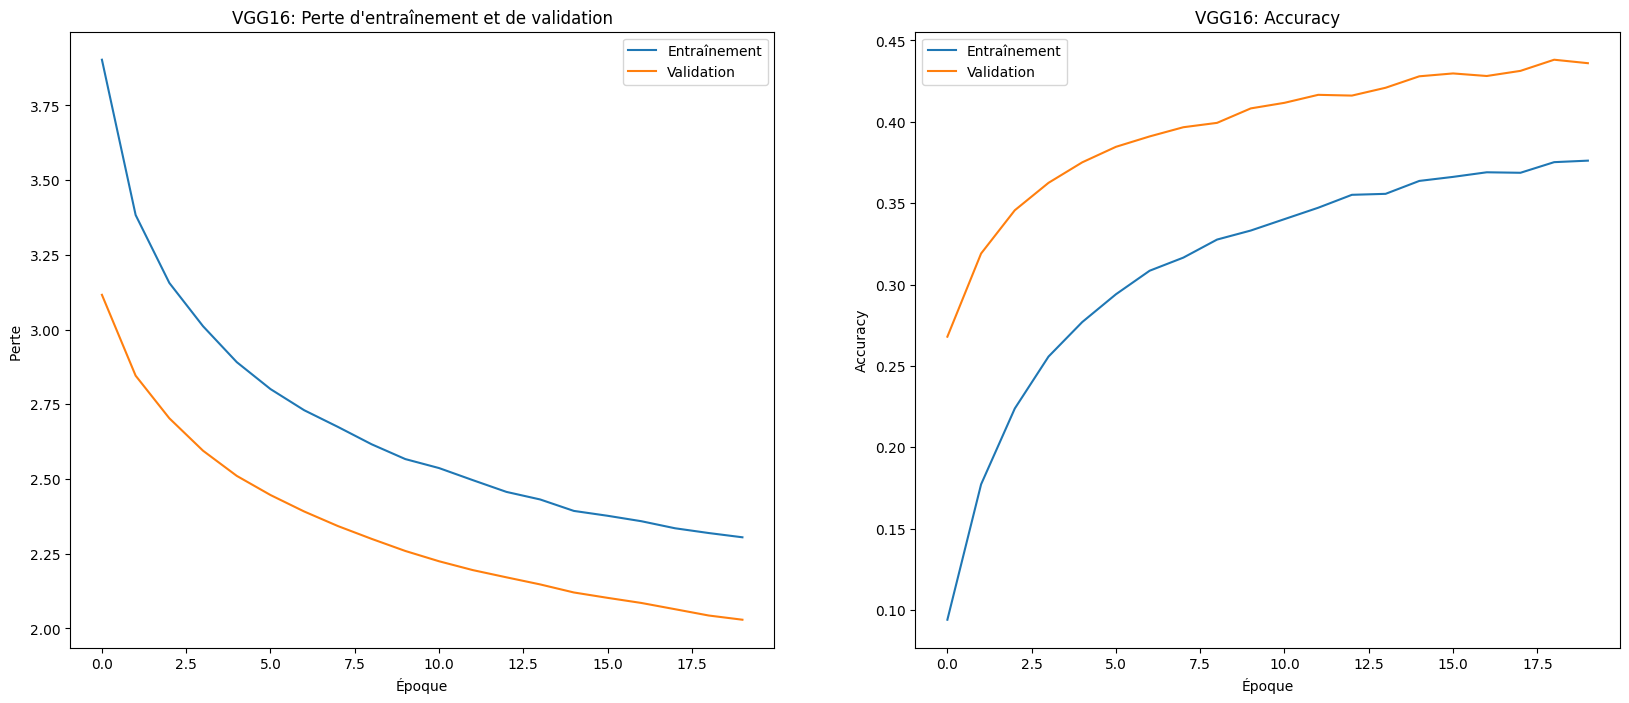

Analyse entrainement VGG16 (fine tunning)


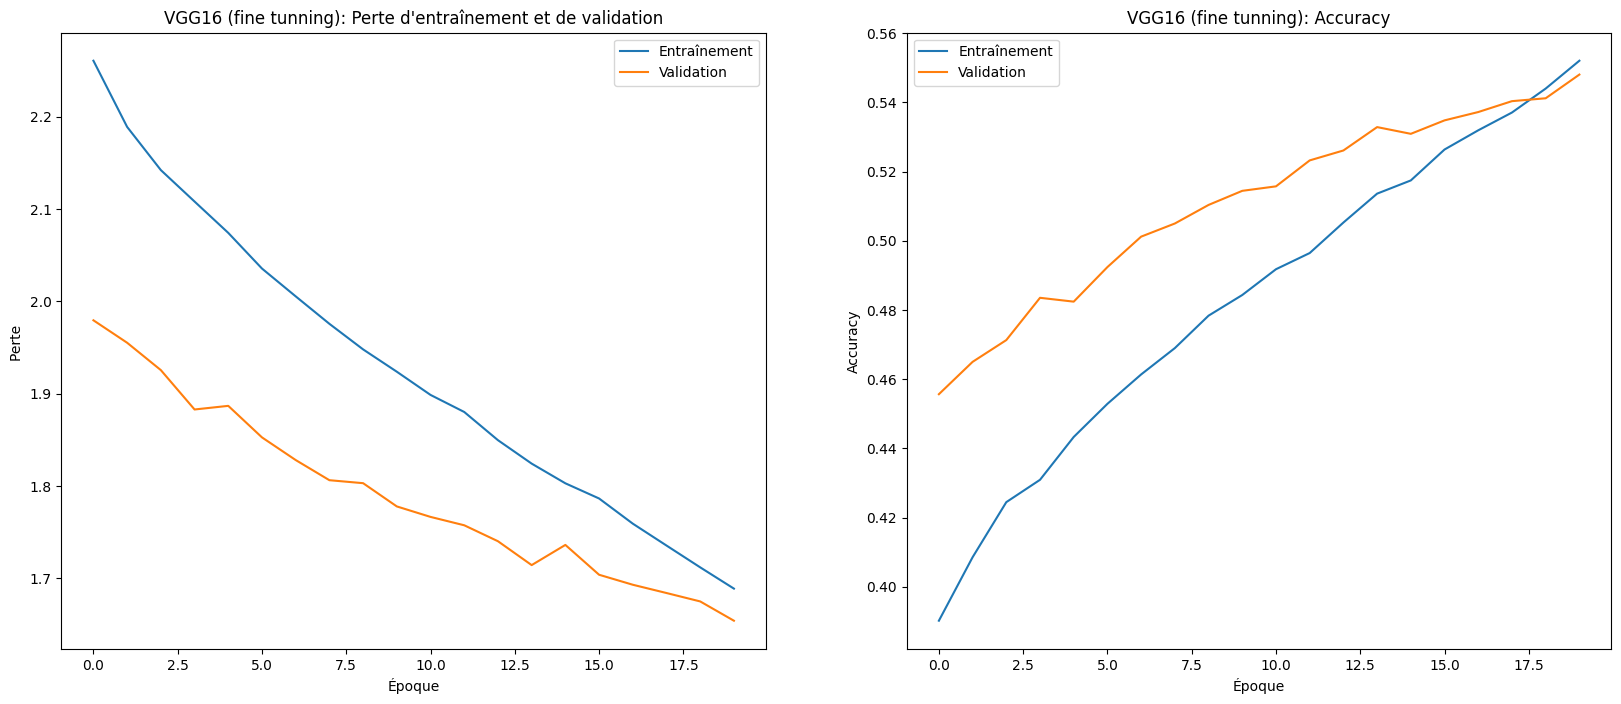

338/338 ━━━━━━━━━━━━━━━━━━━━ 37s 110ms/step - accuracy: 0.5518 - loss: 1.6679


Précision de validation finale: 0.5481


In [2]:


# Définition des callbacks
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'vgg16_best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Étape 2: Entraîner avec le modèle de base gelé
print("Phase 1: Entraînement avec modèle de base gelé")

model.compile(
    loss='sparse_categorical_crossentropy',  
    optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4),                 
    metrics=['accuracy'])  


model_history = model.fit(train_ds,           
                           validation_data=val_ds,
                           epochs=20,
                           callbacks=[lr_reducer, early_stopping, checkpoint])  

# Étape 3: Fine-tuning - dégeler partiellement le modèle de base
print("Phase 2: Fine-tuning")

# Dégeler le 5ème bloc de convolution
for layer in base_model.layers:
    if "block5_" in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

# Vérification des couches dégelées
trainable_layers = [layer.name for layer in base_model.layers if layer.trainable]
print(f"Couches dégelées pour le fine-tuning: {trainable_layers}")

# Recompiler avec un taux d'apprentissage plus faible
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  
    metrics=['accuracy']
)

# Entraîner avec fine-tuning
history_phase2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[lr_reducer, early_stopping, checkpoint]
)

# Analyse de l'entainement
print("Analyse entrainement VGG16 (modèle de base)")
display_results(model_history, "VGG16")

# Analyse de l'entainement
print("Analyse entrainement VGG16 (fine tunning)")
display_results(history_phase2, "VGG16 (fine tunning)")

# Évaluation finale
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Précision de validation finale: {val_accuracy:.4f}")

# Sauvegarde du modèle final
model.save('vgg16_final_model.h5')

## Analyse de la performance par classe

In [18]:
# Chargement des poids
model.load_weights('vgg16_final_model.h5')

# Check
model.summary()


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_6 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_6               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_6 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_6               │ (None, 224, 224, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_6 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 27)             │         3,483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,885,979 (56.79 MB)

 Trainable params: 169,499 (662.11 KB)

 Non-trainable params: 14,716,480 (56.14 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-04-18 16:46:47.523694: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


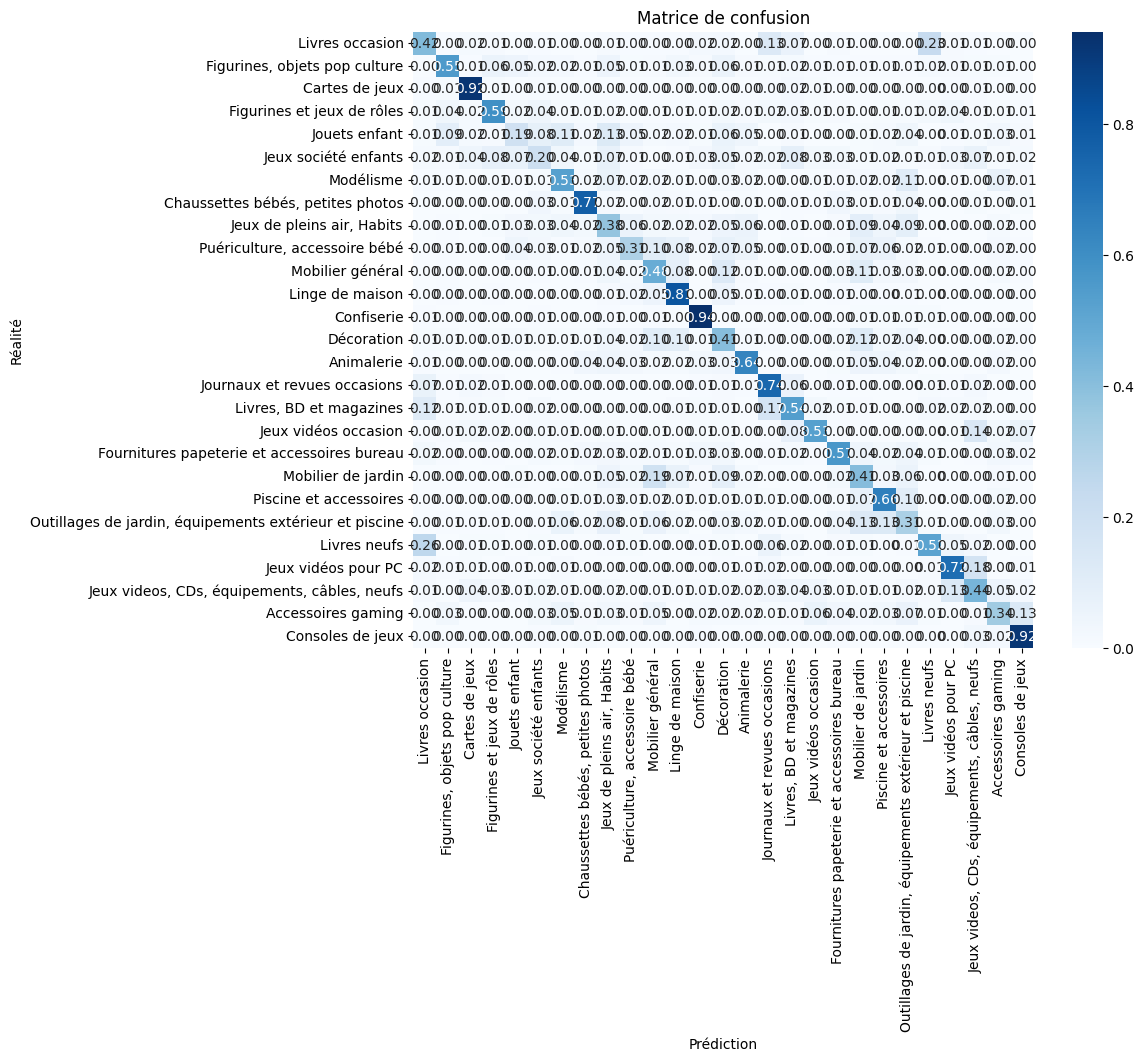

                                                        precision    recall  f1-score   support

                                    Accessoires gaming       0.45      0.34      0.39       398
                                            Animalerie       0.65      0.64      0.65       420
                                        Cartes de jeux       0.81      0.92      0.86       413
                     Chaussettes bébés, petites photos       0.76      0.77      0.77       390
                                            Confiserie       0.76      0.94      0.84       391
                                      Consoles de jeux       0.74      0.92      0.82       407
                                            Décoration       0.33      0.41      0.37       407
                            Figurines et jeux de rôles       0.65      0.59      0.62       380
                         Figurines, objets pop culture       0.67      0.55      0.61       397
           Fournitures papeterie et acc

In [42]:
### ANALYSE DE LA PERFORMACE ###
import seaborn as sns

# 1. Générer des prédictions sur l'ensemble de validation
# Prévoir les classes pour tous les échantillons de validation
predictions = []
labels = []

# Récupérer toutes les étiquettes et prédictions
for images, true_labels in val_ds:
    pred = model.predict(images)
    pred_classes = np.argmax(pred, axis=1)
    
    predictions.extend(pred_classes)
    labels.extend(true_labels.numpy())

# Convertir en arrays numpy
predictions = np.array(predictions)
labels = np.array(labels)

# dictionnaire des catégories
categories = {
    10: "Livres occasion",
    2280: "Journaux et revues occasions",
    2403: "Livres, BD et magazines",
    2522: "Fournitures papeterie et accessoires bureau",
    2705: "Livres neufs",
    40: "Jeux videos, CDs, équipements, câbles, neufs",
    50: "Accessoires gaming",
    60: "Consoles de jeux",
    2462: "Jeux vidéos occasion",
    2905: "Jeux vidéos pour PC",
    1140: "Figurines, objets pop culture",
    1160: "Cartes de jeux",
    1180: "Figurines et jeux de rôles",
    1280: "Jouets enfant",
    1281: "Jeux société enfants",
    1300: "Modélisme",
    1302: "Jeux de pleins air, Habits",
    1560: "Mobilier général",
    2582: "Mobilier de jardin",
    1320: "Puériculture, accessoire bébé",
    2220: "Animalerie",
    2583: "Piscine et accessoires",
    2585: "Outillages de jardin, équipements extérieur et piscine",
    1920: "Linge de maison",
    2060: "Décoration",
    1301: "Chaussettes bébés, petites photos",
    1940: "Confiserie"
}

class_indices = val_ds.class_names # correspondance index vers idcategory
predicted_ids = [class_indices[i] for i in predictions]
true_ids = [class_indices[i] for i in labels]

predicted_cat = [categories.get(int(cid)) for cid in predicted_ids]
true_cat = [categories.get(int(cid)) for cid in true_ids]

real_class_names = [categories.get(int(cid)) for cid in class_indices]

# 2. Créer et afficher la matrice de confusion
cm = confusion_matrix(labels, predictions, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f', xticklabels=real_class_names, yticklabels=real_class_names)
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.title('Matrice de confusion')
plt.show()

print(classification_report(true_cat, predicted_cat))

In [41]:
# Ton dictionnaire
categories = {
    10: "Livres occasion",
    2280: "Journaux et revues occasions",
    2403: "Livres, BD et magazines",
    2522: "Fournitures papeterie et accessoires bureau",
    2705: "Livres neufs",
    40: "Jeux videos, CDs, équipements, câbles, neufs",
    50: "Accessoires gaming",
    60: "Consoles de jeux",
    2462: "Jeux vidéos occasion",
    2905: "Jeux vidéos pour PC",
    1140: "Figurines, objets pop culture",
    1160: "Cartes de jeux",
    1180: "Figurines et jeux de rôles",
    1280: "Jouets enfant",
    1281: "Jeux société enfants",
    1300: "Modélisme",
    1302: "Jeux de pleins air, Habits",
    1560: "Mobilier général",
    2582: "Mobilier de jardin",
    1320: "Puériculture, accessoire bébé",
    2220: "Animalerie",
    2583: "Piscine et accessoires",
    2585: "Outillages de jardin, équipements extérieur et piscine",
    1920: "Linge de maison",
    2060: "Décoration",
    1301: "Chaussettes bébés, petites photos",
    1940: "Confiserie"
}

class_indices = val_ds.class_names
predicted_ids = [class_indices[i] for i in predictions]
true_ids = [class_indices[i] for i in labels]

real_class_names = [categories.get(int(cid)) for cid in class_indices]

real_class_names

['Livres occasion',
 'Figurines, objets pop culture',
 'Cartes de jeux',
 'Figurines et jeux de rôles',
 'Jouets enfant',
 'Jeux société enfants',
 'Modélisme',
 'Chaussettes bébés, petites photos',
 'Jeux de pleins air, Habits',
 'Puériculture, accessoire bébé',
 'Mobilier général',
 'Linge de maison',
 'Confiserie',
 'Décoration',
 'Animalerie',
 'Journaux et revues occasions',
 'Livres, BD et magazines',
 'Jeux vidéos occasion',
 'Fournitures papeterie et accessoires bureau',
 'Mobilier de jardin',
 'Piscine et accessoires',
 'Outillages de jardin, équipements extérieur et piscine',
 'Livres neufs',
 'Jeux vidéos pour PC',
 'Jeux videos, CDs, équipements, câbles, neufs',
 'Accessoires gaming',
 'Consoles de jeux']